In [17]:
import os
import sys
import io
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

In [18]:
HERE = Path(_dh[-1])
DATA = HERE / "data" # sets the path

In [19]:
chembl_df = pd.read_csv(
    HERE / "/home/jovyan/project/a3_ligands_chembl_smiles.txt",
    index_col=0,
)

print("Shape of dataframe:", chembl_df.shape)

chembl_df = chembl_df[["smiles", "pchembl"]] # import the dataframe with pChEMBL values and smiles we just created
chembl_df.head()

Shape of dataframe: (3244, 2)


,smiles,pchembl
0,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,7.150000
1,CCNC(=O)C1OC(n2cnc3c2ncnc3Nc2ccc(OCC(=O)Nc3ccc...,7.470000
2,C#CCn1c(=O)c2c(nc3cc(OC)ccn32)n(Cc2ccccc2)c1=O,8.385000
3,CNC(=O)C12CC1C(n1cnc3c1nc(C#CCCCCC(=O)OC)nc3NC...,7.960000
4,CCCn1c(=O)c2c(nc3cc(OC)ccn32)n(CCCNC(=O)c2ccc(...,6.163333


In [20]:
chembl_df["active"] = np.zeros(len(chembl_df)) # for the cutoff value to work we need to add a new column called active

cutoff_value = 6 #this cutoff value can be changed to 'tune' the model later on

chembl_df.loc[chembl_df[chembl_df.pchembl >= cutoff_value].index, "active"] = 1.0 #everything above the selected cutoff will be considered active

print("Number of active compounds pChEMBL:", int(chembl_df.active.sum()))
print("Number of inactive compounds pChEMBL:", len(chembl_df) - int(chembl_df.active.sum()))
chembl_df.head()

Number of active compounds pChEMBL: 2557
Number of inactive compounds pChEMBL: 687


,smiles,pchembl,active
0,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,7.150000,1.0
1,CCNC(=O)C1OC(n2cnc3c2ncnc3Nc2ccc(OCC(=O)Nc3ccc...,7.470000,1.0
2,C#CCn1c(=O)c2c(nc3cc(OC)ccn32)n(Cc2ccccc2)c1=O,8.385000,1.0
3,CNC(=O)C12CC1C(n1cnc3c1nc(C#CCCCCC(=O)OC)nc3NC...,7.960000,1.0
4,CCCn1c(=O)c2c(nc3cc(OC)ccn32)n(CCCNC(=O)c2ccc(...,6.163333,1.0


In [21]:
def smiles_to_fp(smiles, method="morgan3", n_bits=2048): # function that created the fingerprints, we used morgan3 for our model

    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [22]:
compound_df = chembl_df.copy()

In [23]:
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp)
compound_df.drop(compound_df[compound_df.fp == 'NaN'].index, inplace=True)
compound_df.head(3) # fingerprints are hereby created for each entry

/opt/conda/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


,smiles,pchembl,active,fp
0,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,7.150,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CCNC(=O)C1OC(n2cnc3c2ncnc3Nc2ccc(OCC(=O)Nc3ccc...,7.470,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C#CCn1c(=O)c2c(nc3cc(OC)ccn32)n(Cc2ccccc2)c1=O,8.385,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [24]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=True): # function that creates and saves the roc/auc plot

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"/home/jovyan/project/roc_auc_model1", dpi=300, bbox_inches="tight", transparent=True)
    return fig

In [25]:
def model_performance(ml_model, test_x, test_y, verbose=True): # function that produces measurements of model performance

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [26]:
def model_training_and_validation(ml_model, name, splits, verbose=True):

    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

In [27]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

split=0.2 # the split that is used can be changed here

# split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=split)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]

print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 2595
Test data size: 649


In [28]:
trees_grown=200 # the amount of trees grown can be changed here

param = {
    "n_estimators": trees_grown,  # number of trees to grows (we can change this to try to improve performance)
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param) # defines the model that will be used

In [29]:
performance_measures = model_training_and_validation(model_RF, "RF", splits) # prints the performance measurements of the model

Accuracy: 0.87
Sensitivity: 0.97
Specificity: 0.49
AUC: 0.91


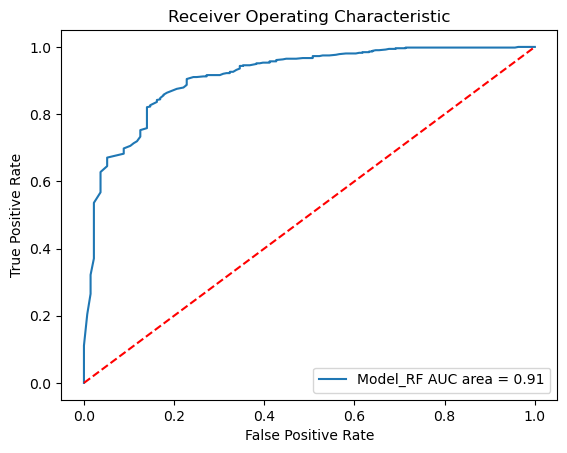

In [30]:
models = [{"label": "Model_RF", "model": model_RF}] # prints the roc/auc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

Directory already exists, continuing


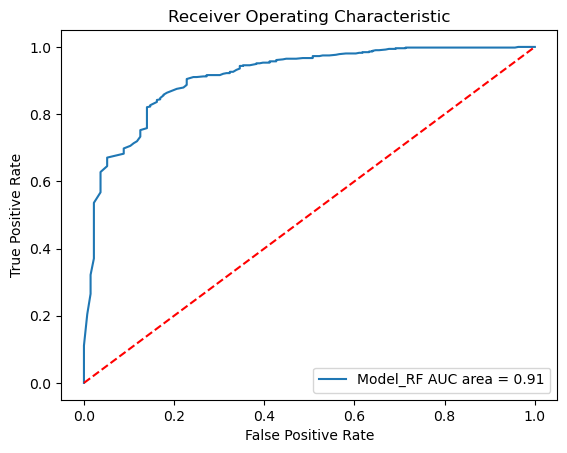

In [31]:
models = [{"label": "Model_RF", "model": model_RF}]
try:
    os.mkdir('results')
except:
    print("Directory already exists, continuing")
plot_roc_curves_for_models(models, static_test_x, static_test_y)
result_img = '/home/joyvan/project/roc_auc_model1.png'.format(os.getcwd()) # where to save the curve

In [32]:
#test_smiles = pd.read_csv("/home/jovyan/project/zinc_adenosine.txt")

#test_smiles = pd.read_csv("/home/jovyan/project/a3_ligands_ki_smiles.txt")
#test_smiles.reset_index(drop=False, inplace=True)
#test_smiles.drop(columns=['Unnamed: 0'],inplace=True) 
#test_smiles.drop(columns=['index'],inplace=True) #now the index is right
#display(test_smiles)

# different imports of dataset to the model on for predictions
# eventually we decided the just use smiles strings as text because inserting files did not work

In [33]:
test_smiles = [ # the smiles that were used to make predictions on are inserted here
                # this selection was made by Amine based on literature
'Cc1ccc(NC(=O)Nc2nc3nn(C)cc3c3nc(-c4ccco4)nn23)cc1',
'Cn1cc2c(nc(NC(=O)Nc3ccc(F)cc3)n3nc(-c4ccco4)nc23)n1',
'Cn1cc2c(nc(NC(=O)Nc3ccc(Cl)cc3)n3nc(-c4ccco4)nc23)n1',
'Cn1cc2c(nc(NC(=O)Nc3ccc(Br)cc3)n3nc(-c4ccco4)nc23)n1',
'COc1ccc(NC(=O)Nc2nc3nn(C)cc3c3nc(-c4ccco4)nn23)cc1',
'Cn1cc2c(nc(NC(=O)Nc3cc[n+]([O-])cc3)n3nc(-c4ccco4)nc23)n1',
'Cn1cc2c(nc(NC(=O)Nc3ccc(Cl)c(Cl)c3)n3nc(-c4ccco4)nc23)n1',
'Cn1cc2c(nc(NC(=O)Nc3cccc(Cl)c3)n3nc(-c4ccco4)nc23)n1',
'COc1cccc(NC(=O)Nc2nc3nn(C)cc3c3nc(-c4ccco4)nn23)c1',
'Cn1cc2c(nc(NC(=O)Nc3ccc[n+](C)c3)n3nc(-c4ccco4)nc23)n1',
'Cn1cc2c(nc(NC(=O)Nc3ccc[n+]([O-])c3)n3nc(-c4ccco4)nc23)n1',
'Cn1cc2c(nc(NC(=O)Nc3ccccc3Cl)n3nc(-c4ccco4)nc23)n1',
'COc1ccccc1NC(=O)Nc1nc2nn(C)cc2c2nc(-c3ccco3)nn12',
'Cn1cc2c(nc(NC(=O)Nc3ccco3)n3nc(-c4ccco4)nc23)n1',
'Cn1cc2c(nc(NC(=O)Nc3cccc[n+]3C)n3nc(-c4ccco4)nc23)n1',
'Cn1cc2c(nc(NC(=O)Nc3cccc[n+]3[O-])n3nc(-c4ccco4)nc23)n1',
'CCn1cc2c(nc(NC(=O)Nc3ccccc3)n3nc(-c4ccco4)nc23)n1',
'Cn1cc2c(nc(NC(=O)Nc3ccoc3)n3nc(-c4ccco4)nc23)n1',
'CCCn1cc2c(nc(NC(=O)Nc3ccccc3)n3nc(-c4ccco4)nc23)n1',
'CCn1cc2c(nc(NC(=O)Nc3ccc(C)cc3)n3nc(-c4ccco4)nc23)n1',
'CCn1cc2c(nc(NC(=O)Nc3ccc(F)cc3)n3nc(-c4ccco4)nc23)n1',
'Cn1cc2c(nc(NC(=O)Nc3ccc(Cl)cc3)n3nc(-c4ccco4)nc23)n1',
'Cc1ccc(NC(=O)Nc2nc3nn(C)cc3c3nc(-c4ccco4)nn23)s1',
'CCn1cc2c(nc(NC(=O)Nc3ccc(Br)cc3)n3nc(-c4ccco4)nc23)n1',
'O=C(Nc1cccnc1)Nc1nc2nn(CCO)cc2c2nc(-c3ccco3)nn12',
'Cc1sccc1NC(=O)Nc1nc2nn(C)cc2c2nc(-c3ccco3)nn12',
'Cn1cc2c(nc(NC(=O)COc3ccccc3)n3nc(-c4ccco4)nc23)n1',
'Cn1cc2c(nc(NC(=O)Cc3ccc(Cl)cc3)n3nc(-c4ccco4)nc23)n1',
'Cn1cc2c(nc(NC(=O)Cc3ccc(F)cc3)n3nc(-c4ccco4)nc23)n1',
'COc1ccc(NC(=O)Nc2nc3cn(C)cc3c3nc(-c4ccco4)nn23)cc1',
'CCn1cc2c(nc(NC(=O)Nc3cccc(Cl)c3)n3nc(-c4ccco4)nc23)n1',
'COc1ccc(CC(=O)Nc2nc3nn(C)cc3c3nc(-c4ccco4)nn23)cc1',
'Cn1cc2c(nc(NC(=O)Cc3c(Cl)cccc3Cl)n3nc(-c4ccco4)nc23)n1',
'Cn1ccc(=NC(=O)Nc2nc3nn(C)cc3c3nc(-c4ccco4)nn23)cc1',
'Cn1cc2c(nc(NC(=O)Cc3cccc(Cl)c3)n3nc(-c4ccco4)nc23)n1',
'Cn1cc2c(nc(NC(=O)N=c3ccccn3C)n3nc(-c4ccco4)nc23)n1',
'Cn1cc2c(nc(NC(=O)Cc3cccs3)n3nc(-c4ccco4)nc23)n1',
'Cn1cc2c(nc(NC(=O)/N=c3\ccccn3C)n3nc(-c4ccco4)nc23)n1',
'CCn1cc2c(nc(NC(=O)Nc3ccccc3Cl)n3nc(-c4ccco4)nc23)n1',
'Cn1cc2c(nc(NC(=O)Cc3ccsc3)n3nc(-c4ccco4)nc23)n1',
'O=C(Nc1cccc(Cl)c1)Nc1nc2n[nH]cc2c2nc(-c3ccco3)nn12',
'CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc23)n1',
'CCCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc23)n1',
'CCNc1nc(C#C[C@@H](O)c2ccccc2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'CCNc1nc(C#C[C@H](O)c2ccccc2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'CCNc1nc(C#Cc2ccccc2)nc2c1ncn2[C@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'CCNc1nc(C#Cc2ccccc2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'C[C@H](Cc1ccccc1)Nc1ncnc2n(cnc12)[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cnc2c(NC3Cc4ccccc4C3)ncnc12',
'OCC1OC(C(O)C1O)n1cnc2c(NCCc3ccccc3)ncnc12',
'OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cnc2c(NCCc3ccccc3)ncnc12',
'Nc1ccc(CCNc2ncnc3n(cnc23)[C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)cc1',
'OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cnc2c(NCCc3ccc(O)cc3)ncnc12',
'OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cnc2c(NC3CCCC3)ncnc12',
'OCC1OC(C(O)C1O)n1cnc2c(NC3CCCCC3)ncnc12',
'OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cnc2c(NC3CCCCC3)ncnc12',
'C[C@@]1(O)[C@H](O)[C@@H](CO)O[C@H]1n1cnc2c(NC3CCCC3)ncnc12',
'OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cnc2c(N[C@H]3CCC[C@@H]3O)ncnc12',
'OCCCCNc1ncnc2n(cnc12)C1OC(CO)C(O)C1O',
'CNc1nc(C#C[C@@H](O)c2ccccc2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'CNc1nc(C#C[C@H](O)c2ccccc2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'CC(C)Nc1nc(C#C[C@@H](O)c2ccccc2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'CC(C)Nc1nc(C#C[C@H](O)c2ccccc2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'Nc1nc(C#C[C@H](O)c2ccccc2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@H](O)[C@H]1O',
'Nc1nc(C#C[C@H](O)c2ccccc2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@H](O)[C@@H]1O',
'Nc1nc(C#C[C@@H](O)c2ccccc2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@H](O)[C@@H]1O',
'Nc1nc(C#C[C@H](O)c2ccccc2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'Nc1nc(C#C[C@@H](O)c2ccccc2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@H](O)[C@H]1O',
'Nc1nc(C#C[C@@H](O)c2ccccc2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'CONc1nc(C#Cc2ccccc2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'CONc1nc(C#Cc2ccccc2)nc2c1ncn2[C@@H]1O[C@@H](CO)[C@@H](O)[C@H]1O',
'CCNc1nc(OCc2ccccc2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'CONc1nc(C#Cc2ccncc2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'CONc1nc(C#Cc2cccnc2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'CONc1nc(C#Cc2ccccn2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'Nc1nc(NC[C@H](O)c2ccccc2)nc2c1ncn2[C@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'Nc1nc(NC[C@@H](O)c2ccccc2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'Nc1nc(NC[C@H](O)c2ccccc2)nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'Nc1nc(NC[C@@H](O)c2ccccc2)nc2c1ncn2[C@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'Cn1cnc2n([13CH3])c(=O)n(C)c(=O)c12',
'Cn1c(Br)nc2n(C)c(=O)n(C)c(=O)c12',
'CC(CO)=CCNc1ncnc2n(cnc12)[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'C\C(CO)=C\CNc1ncnc2n(cnc12)[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'[2H]C([2H])([2H])n1c(=O)n(C)c2ncn(C)c2c1=O',
'Cn1cnc2[15n](C)[13c](=O)[15n](C)c(=O)c12',
'[2H]C([2H])([2H])n1cnc2[nH]c(=O)n(c(=O)c12)C([2H])([2H])[2H]',
'CCn1cnc2n(C)c(=O)n(C)c(=O)c12',
'Cn1c2c([nH]c1=O)[nH]c(=O)n(C)c2=O',
'CC(C)Cn1cnc2n(C)c(=O)n(C)c(=O)c12',
'Cn1c2ncn(CCC#N)c2c(=O)n(C)c1=O',
'COc1ccc(CC(N)C(=O)NC2[C@@H](CO)O[C@H]([C@H]2O)n2cnc3c(ncnc23)N(C)C)cc1',
'OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cnc2c(NCc3ccc(O)cc3)ncnc12',
'CN(C)c1ncnc2n(cnc12)C1OC(CO)C(N)C1O',
'OC[C@H]1O[C@H](C[C@@H]1N=[N+]=[N-])n1cnc2c(NC(=O)c3ccccc3)ncnc12',
'OC[C@H]1O[C@H]([C@H](O)[C@@H]1F)n1cnc2c(NC(=O)c3ccccc3)ncnc12',
'OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cnc2c(N[C@@H](CC(O)=O)C(O)=O)ncnc12',
'Nc1nc2c(N)ncnc2n1[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'NC1NC=Nc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
'OC[C@H]1O[C@H](O)[C@@H](O)[C@H](O)[C@H]1O',
'OC[C@H]1O[C@H](O)[C@@H](O)[C@@H](O)[C@H]1O',
'OC[C@@H]1O[C@@H](O)[C@H](O)[C@H](O)[C@@H]1O',
'OC[C@@H]1O[C@@H](O)[C@@H](O)[C@H](O)[C@@H]1O',
'OC[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O',
'OC[C@@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O',
'OC[C@@H]1O[C@H](O)[C@@H](O)[C@H](O)[C@@H]1O',
'OC[C@@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@@H]1O',
'OC[C@H]1O[C@@H](O)[C@@H](O)[C@@H](O)[C@H]1O',
'OC[C@H]1O[C@@H](O)[C@@H](O)[C@@H](O)[C@@H]1O',
'OC[C@H]1O[C@@H](O)[C@@H](O)[C@H](O)[C@H]1O',
'OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@@H]1O',
'OC[C@@H]1O[C@H](O)[C@H](O)[C@H](O)[C@H]1O',
'OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@H]1O',
'OC[C@@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@H]1O',
'OC[C@@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@H]1O',
'OC[C@@H]1O[C@H](O)[C@@H](O)[C@@H](O)[C@@H]1O',
'OC[C@@H]1O[C@H](O)[C@H](O)[C@H](O)[C@@H]1O',
'OC[C@H]1O[C@@H](O)[C@H](O)[C@H](O)[C@@H]1O',
'OC[C@@H]1O[C@@H](O)[C@H](O)[C@H](O)[C@H]1O',
'OC[C@@H]1O[C@H](O)[C@@H](O)[C@@H](O)[C@H]1O',
'OC[C@@H]1O[C@H](O)[C@@H](O)[C@H](O)[C@H]1O',
'OC[C@@H]1O[C@@H](O)[C@@H](O)[C@H](O)[C@H]1O',
'OC[C@H]1O[C@H](O)[C@@H](O)[C@@H](O)[C@@H]1O',
'OC[C@H]1O[C@@H](O)[C@H](O)[C@H](O)[C@H]1O',
'OC[C@@H]1O[C@@H](O)[C@@H](O)[C@@H](O)[C@@H]1O',
'OC[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@H]1O',
'OC[C@@H]1O[C@@H](O)[C@@H](O)[C@@H](O)[C@H]1O',
'OC[C@H]1O[C@@H](O)[C@@H](O)[C@H](O)[C@@H]1O',
'OC[C@H]1O[C@H](O)[C@@H](O)[C@H](O)[C@@H]1O',
'O=c1[nH]c(=O)c2[nH]cnc2[nH]1',
'N[C@@H]1NC(=O)c2[nH]cnc2N1',
'N[C@H]1NC(=O)c2[nH]cnc2N1',
'O=C1Cc2nc[nH]c2C(=O)N1',
'Nc1cc(=O)[nH]c2nc[nH]c12',
'Nc1nc(=O)[nH]c2nc[nH]c12',
'O=c1nc(Cl)c2[nH]cnc2[nH]1',
'O=c1[nH]c(F)nc2nc[nH]c12',
'O=C1Nc2nc[nH]c2[C@H](S)N1',
'O=C1Nc2nc[nH]c2[C@@H](S)N1',
'Nc1nc2ccc(Cl)cc2c2nc(-c3ccco3)nn12',
'Nc1nc2ccccc2c2nc(-c3ccco3)nn12',
'Oc1nc2ccc(Cl)cc2c2nc(-c3ccco3)nn12',
'Nc1nc2ccc(O)cc2c2nc(-c3ccco3)nn12',
'Nc1nc2ccc(F)cc2c2nc(-c3ccco3)nn12',
'COc1ccc2nc(N)n3nc(-c4ccco4)nc3c2c1',
'CNc1nc2ccc(Cl)cc2c2nc(-c3ccco3)nn12',
'Nc1nc2ccc(Cl)cc2c2nc(-c3ccc(Br)o3)nn12',
'Nc1nc2ccc(Cl)cc2c2nc(-c3ccc[nH]3)nn12',
'Nc1nc2ccc(Cl)cc2c2nc(-c3cccs3)nn12',
'Nc1nc2ccc(Cl)cc2c2nc(-c3ccoc3)nn12',
'O=c1oc2ccc(Cl)cc2c2nc(-c3ccco3)nn12',
'Sc1nc2ccccc2c2nc(-c3ccco3)nn12',
'Oc1nc2ccccc2c2nc(-c3ccco3)nn12',
'Cc1nc2ccccc2c2nc(-c3ccco3)nn12',
'Nc1nc2ccc(Cl)cc2c2nc([C@H]3CCCO3)nn12',
'Nc1nc2ccc(Cl)cc2c2nc([C@@H]3CCCO3)nn12',
'Oc1nc2ccc(Cl)cc2c2cc(-c3ccco3)nn12',
'Nc1nc2ccccc2c2cc(-c3ccco3)nn12',
'Oc1nc2ccc(Cl)cc2c2nc(-c3ccoc3)nn12',
'Oc1nc2ccc(Cl)cc2c2nc(-c3cccs3)nn12',
'O=c1oc2ccccc2c2nc(-c3ccco3)nn12',
'O=c1[nH]c2ccc(Cl)cc2n2nc(-c3ccco3)nc12',
'Nc1nc2ccccc2n2nc(-c3ccco3)nc12'
]

fps = []

for smiles in test_smiles: 
    fp = smiles_to_fp(smiles,'morgan3')
    fps.append(fp)

predictions = model_RF.predict(fps)

print("SMILES, PREDICTION")
count_1 = 0
count_0 = 0
for i, prediction in enumerate(predictions):
    print(f'{test_smiles[i]}, {prediction}')
    if prediction == 1.0:
        count_1 += 1
    elif prediction == 0.0:
        count_0 += 1

SMILES, PREDICTION
Cc1ccc(NC(=O)Nc2nc3nn(C)cc3c3nc(-c4ccco4)nn23)cc1, 1.0
Cn1cc2c(nc(NC(=O)Nc3ccc(F)cc3)n3nc(-c4ccco4)nc23)n1, 1.0
Cn1cc2c(nc(NC(=O)Nc3ccc(Cl)cc3)n3nc(-c4ccco4)nc23)n1, 1.0
Cn1cc2c(nc(NC(=O)Nc3ccc(Br)cc3)n3nc(-c4ccco4)nc23)n1, 1.0
COc1ccc(NC(=O)Nc2nc3nn(C)cc3c3nc(-c4ccco4)nn23)cc1, 1.0
Cn1cc2c(nc(NC(=O)Nc3cc[n+]([O-])cc3)n3nc(-c4ccco4)nc23)n1, 1.0
Cn1cc2c(nc(NC(=O)Nc3ccc(Cl)c(Cl)c3)n3nc(-c4ccco4)nc23)n1, 1.0
Cn1cc2c(nc(NC(=O)Nc3cccc(Cl)c3)n3nc(-c4ccco4)nc23)n1, 1.0
COc1cccc(NC(=O)Nc2nc3nn(C)cc3c3nc(-c4ccco4)nn23)c1, 1.0
Cn1cc2c(nc(NC(=O)Nc3ccc[n+](C)c3)n3nc(-c4ccco4)nc23)n1, 1.0
Cn1cc2c(nc(NC(=O)Nc3ccc[n+]([O-])c3)n3nc(-c4ccco4)nc23)n1, 1.0
Cn1cc2c(nc(NC(=O)Nc3ccccc3Cl)n3nc(-c4ccco4)nc23)n1, 1.0
COc1ccccc1NC(=O)Nc1nc2nn(C)cc2c2nc(-c3ccco3)nn12, 1.0
Cn1cc2c(nc(NC(=O)Nc3ccco3)n3nc(-c4ccco4)nc23)n1, 1.0
Cn1cc2c(nc(NC(=O)Nc3cccc[n+]3C)n3nc(-c4ccco4)nc23)n1, 1.0
Cn1cc2c(nc(NC(=O)Nc3cccc[n+]3[O-])n3nc(-c4ccco4)nc23)n1, 1.0
CCn1cc2c(nc(NC(=O)Nc3ccccc3)n3nc(-c4ccco4)nc23)n1, 1.

In [34]:
original_stdout = sys.stdout
captured_output = io.StringIO()
sys.stdout = captured_output

# a selection of all values, as well as the smiles and predictions, to be saved in a file for every run

print("MODEL SPECS")
print("Cutoff value:",cutoff_value)
print("Number of active compounds:", int(chembl_df.active.sum()))
print("Number of inactive compounds:", len(chembl_df) - int(chembl_df.active.sum()))
print("Split:",split)
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))
print("Amount of trees grown:",trees_grown)
pmfloat = tuple(round(x, 2) for x in performance_measures)
print("The model: Acc, Sens, Spec, AUC",pmfloat)
print("")
print(f"Count of 1.0: {count_1}")
print(f"Count of 0.0: {count_0}")
print("")
print("SMILES and PREDICTION")
count_1 = 0
count_0 = 0
for i, prediction in enumerate(predictions):
    print(f'{test_smiles[i]}, {prediction}')
    if prediction == 1.0:
        count_1 += 1
    elif prediction == 0.0:
        count_0 += 1
        
output_string = captured_output.getvalue()
sys.stdout = original_stdout

directory = '/home/jovyan/project/results'
counter = 1
filename_pattern = 'model1_result{}.txt'
file_path = os.path.join(directory, filename_pattern.format(counter))
while os.path.exists(file_path):
    counter += 1
    file_path = os.path.join(directory, filename_pattern.format(counter))
with open(file_path, 'w') as f:
    f.write(output_string)
    
print(f"Output saved at: {file_path}")
print(output_string)

# by examining the models performance and altering values, the classification results were improved throughout the runs
# eventually we selected some ligands for further investigation

Output saved at: /home/jovyan/project/results/model1_result19.txt
MODEL SPECS
Cutoff value: 6
Number of active compounds: 2557
Number of inactive compounds: 687
Split: 0.2
Training data size: 2595
Test data size: 649
Amount of trees grown: 200
The model: Acc, Sens, Spec, AUC (0.87, 0.97, 0.49, 0.91)

Count of 1.0: 160
Count of 0.0: 2

SMILES and PREDICTION
Cc1ccc(NC(=O)Nc2nc3nn(C)cc3c3nc(-c4ccco4)nn23)cc1, 1.0
Cn1cc2c(nc(NC(=O)Nc3ccc(F)cc3)n3nc(-c4ccco4)nc23)n1, 1.0
Cn1cc2c(nc(NC(=O)Nc3ccc(Cl)cc3)n3nc(-c4ccco4)nc23)n1, 1.0
Cn1cc2c(nc(NC(=O)Nc3ccc(Br)cc3)n3nc(-c4ccco4)nc23)n1, 1.0
COc1ccc(NC(=O)Nc2nc3nn(C)cc3c3nc(-c4ccco4)nn23)cc1, 1.0
Cn1cc2c(nc(NC(=O)Nc3cc[n+]([O-])cc3)n3nc(-c4ccco4)nc23)n1, 1.0
Cn1cc2c(nc(NC(=O)Nc3ccc(Cl)c(Cl)c3)n3nc(-c4ccco4)nc23)n1, 1.0
Cn1cc2c(nc(NC(=O)Nc3cccc(Cl)c3)n3nc(-c4ccco4)nc23)n1, 1.0
COc1cccc(NC(=O)Nc2nc3nn(C)cc3c3nc(-c4ccco4)nn23)c1, 1.0
Cn1cc2c(nc(NC(=O)Nc3ccc[n+](C)c3)n3nc(-c4ccco4)nc23)n1, 1.0
Cn1cc2c(nc(NC(=O)Nc3ccc[n+]([O-])c3)n3nc(-c4ccco4)nc23)n1,